# Training the neural network

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## 1. Batch Normalization

In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [4]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

## Transfer Learning

In [5]:
import numpy as np

In [6]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [7]:
tf.random.set_seed(42)

In [8]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(hidden, activation="relu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss=keras.losses.sparse_categorical_crossentropy,
               optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 1.9539 - accuracy: 0.2246 - val_loss: 1.4420 - val_accuracy: 0.6579
Epoch 2/20
1375/1375 [==============================] - 1s 1ms/step - loss: 1.1829 - accuracy: 0.7351 - val_loss: 0.5949 - val_accuracy: 0.8386
Epoch 3/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.5492 - accuracy: 0.8408 - val_loss: 0.4457 - val_accuracy: 0.8563
Epoch 4/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.4400 - accuracy: 0.8563 - val_loss: 0.3913 - val_accuracy: 0.8697
Epoch 5/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.3872 - accuracy: 0.8693 - val_loss: 0.3583 - val_accuracy: 0.8779
Epoch 6/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.3577 - accuracy: 0.8779 - val_loss: 0.3533 - val_accuracy: 0.8744
Epoch 7/20
1375/1375 [==============================] - 1s 1ms/step - loss: 0.3419 - accuracy: 0.8831 - val_loss: 0.3386 - val_accuracy:

In [14]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_A` and `model_B_on_A` now share some layers. When you train `model_B_on_A`, it will also affect `model_A`. If you want to avoid that, you need to clone `model_A` before you reuse its layers. To do this, you must clone `model_A`’s architecture, then copy its weights

In [15]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [16]:
model_B_on_A.summary(), model_A.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

(None, None)

Now we could just train model_B_on_A for task B, but since the new output layer was
initialized randomly, it will make large errors, at least during the first few epochs, so
there will be large error gradients that may wreck the reused weights. To avoid this,
one approach is to freeze the reused layers during the first few epochs, giving the new
layer some time to learn reasonable weights. To do this, simply set every layer’s train
able attribute to False and compile the model:

In [17]:
for layer in model_B_on_A.layers[:-1]:   ## Freezing the layers
    layer.trainable = False

Next, we can train the model for a few epochs, then unfreeze the reused layers (which
requires compiling the model again) and continue training to fine-tune the reused
layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce
the learning rate, once again to avoid damaging the reused weights:

In [18]:
model_B_on_A.compile(loss=keras.losses.binary_crossentropy,
                    optimizer=keras.optimizers.SGD(lr=1e-3),
                    metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, 
                          validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:   ## Un-Freeze the layers
    layer.trainable = True
    
model_B_on_A.compile(loss=keras.losses.binary_crossentropy,     ## Need to re-compile after un-freezing
                    optimizer=keras.optimizers.SGD(lr=1e-3),    ## Lower leraning rate after un-freezing 
                    metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, 
                          validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 25ms/step - loss: 0.6693 - accuracy: 0.4786 - val_loss: 0.6283 - val_accuracy: 0.4990
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 0.5934 - accuracy: 0.5019 - val_loss: 0.5715 - val_accuracy: 0.5000
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.5306 - accuracy: 0.5224 - val_loss: 0.5267 - val_accuracy: 0.5101
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.4938 - accuracy: 0.5150 - val_loss: 0.4887 - val_accuracy: 0.5598
Epoch 1/16
7/7 [==============================] - 0s 25ms/step - loss: 0.4562 - accuracy: 0.6076 - val_loss: 0.4082 - val_accuracy: 0.8002
Epoch 2/16
7/7 [==============================] - 0s 10ms/step - loss: 0.3683 - accuracy: 0.8258 - val_loss: 0.3511 - val_accuracy: 0.9158
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.3133 - accuracy: 0.9418 - val_loss: 0.3144 - val_accuracy: 0.9533
Epoch 4/16
7/7 [===================

In [19]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1481 - accuracy: 0.9930


[0.14813223481178284, 0.9929999709129333]

# Learning Rate Scheduling

## - Power Scheduling

lr = lr0 / (1 + steps / s)**c

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-4),
             metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=25,
                   validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7771 - accuracy: 0.7370 - val_loss: 0.4698 - val_accuracy: 0.8374
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4661 - accuracy: 0.8340 - val_loss: 0.4194 - val_accuracy: 0.8556
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4289 - accuracy: 0.8468 - val_loss: 0.4633 - val_accuracy: 0.8250
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4126 - accuracy: 0.8536 - val_loss: 0.4000 - val_accuracy: 0.8596
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4074 - accuracy: 0.8554 - val_loss: 0.3894 - val_accuracy: 0.8642
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3841 - accuracy: 0.8638 - val_loss: 0.3847 - val_accuracy: 0.8664
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3795 - accuracy: 0.8658 - val_loss: 0.3804 - val_accuracy:

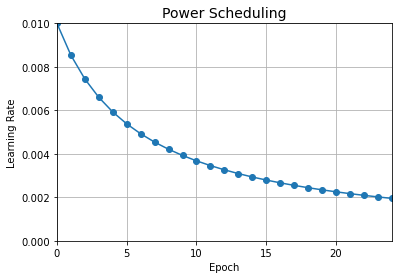

In [24]:
import math
import matplotlib.pyplot as plt

lr = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train)/batch_size)
epochs = np.arange(25)
lrs = lr/(1 + decay*epochs*n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, 25 - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Exponential Scheduling

lr = lr0 * 0.1**(epoch / s)

In [34]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

e_decay_fn = exponential_decay(lr0=0.01, s=20)

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer="nadam",
             metrics=["accuracy"])

In [37]:
lr_scheduler = keras.callbacks.LearningRateScheduler(e_decay_fn)
n_epochs = 25

history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0758 - accuracy: 0.7149 - val_loss: 0.6982 - val_accuracy: 0.7758
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5207 - accuracy: 0.8215 - val_loss: 0.4605 - val_accuracy: 0.8346
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4653 - accuracy: 0.8452 - val_loss: 0.6081 - val_accuracy: 0.8070
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4109 - accuracy: 0.8579 - val_loss: 0.3961 - val_accuracy: 0.8672
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3841 - accuracy: 0.8678 - val_loss: 0.3966 - val_accuracy: 0.8742
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3457 - accuracy: 0.8800 - val_loss: 0.3656 - val_accuracy: 0.8826
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3254 - accuracy: 0.8864 - val_loss: 0.3665 - val_accuracy

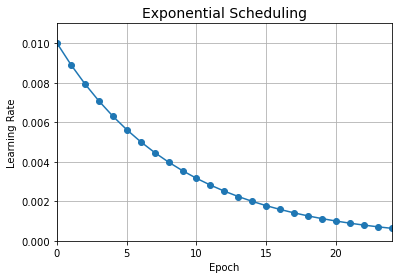

In [47]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [49]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1/20)

K = keras.backend
class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
        
    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr*0.1**(1/s))
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0294 - accuracy: 0.7136 - val_loss: 1.0748 - val_accuracy: 0.6930
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5308 - accuracy: 0.8193 - val_loss: 0.4736 - val_accuracy: 0.8370
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4554 - accuracy: 0.8433 - val_loss: 0.8365 - val_accuracy: 0.7486
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4084 - accuracy: 0.8575 - val_loss: 0.3806 - val_accuracy: 0.8762
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3878 - accuracy: 0.8630 - val_loss: 0.3425 - val_accuracy: 0.8858
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3428 - accuracy: 0.8788 - val_loss: 0.3841 - val_accuracy: 0.8790
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3256 - accuracy: 0.8864 - val_loss: 0.3597 - val_accu

In [50]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

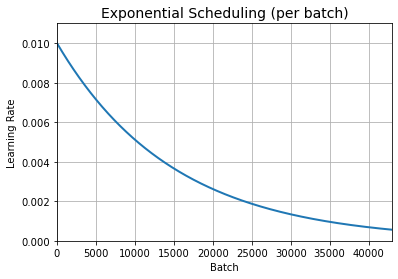

In [51]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

## Performance Scheduling

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [54]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6725 - accuracy: 0.7604 - val_loss: 0.5275 - val_accuracy: 0.8316
Epoch 2/25
1719/1719 [==============================] - 2s 985us/step - loss: 0.4500 - accuracy: 0.8378 - val_loss: 0.4687 - val_accuracy: 0.8356
Epoch 3/25
1719/1719 [==============================] - 2s 977us/step - loss: 0.4327 - accuracy: 0.8454 - val_loss: 0.3776 - val_accuracy: 0.8622
Epoch 4/25
1719/1719 [==============================] - 2s 996us/step - loss: 0.4013 - accuracy: 0.8559 - val_loss: 0.3850 - val_accuracy: 0.8652
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3883 - accuracy: 0.8598 - val_loss: 0.3578 - val_accuracy: 0.8678
Epoch 6/25
1719/1719 [==============================] - 2s 991us/step - loss: 0.3647 - accuracy: 0.8687 - val_loss: 0.3930 - val_accuracy: 0.8734
Epoch 7/25
1719/1719 [==============================] - 2s 988us/step - loss: 0.3638 - accuracy: 0.8707 - val_loss: 0.3802 - val

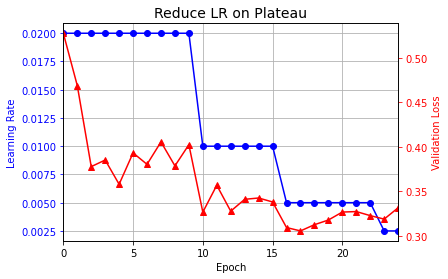

In [55]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

## Monte_Carlo Dropout

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

In [57]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [64]:
np.round(model.predict(X_test[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [66]:
np.round(y_proba[:1], 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Exercise

Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.

In [68]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for i in range(20):
    model.add(keras.layers.Dense(100, activation="elu",
                                kernel_initializer="he_normal"))

Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.

In [70]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [69]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [71]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer=optimizer,
             metrics=["accuracy"])

In [74]:
es = keras.callbacks.EarlyStopping(patience=20, verbose=1)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
                         callbacks=[es, mc])

Epoch 1/100
1407/1407 [==============================] - 12s 7ms/step - loss: 9.3779 - accuracy: 0.1355 - val_loss: 2.1596 - val_accuracy: 0.2210
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 2.1011 - accuracy: 0.2371 - val_loss: 2.1019 - val_accuracy: 0.2350
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.9651 - accuracy: 0.2826 - val_loss: 2.2488 - val_accuracy: 0.2066
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8794 - accuracy: 0.3130 - val_loss: 1.9445 - val_accuracy: 0.3098
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8086 - accuracy: 0.3440 - val_loss: 1.7809 - val_accuracy: 0.3472
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7549 - accuracy: 0.3637 - val_loss: 1.7516 - val_accuracy: 0.3692
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7103 - accuracy: 0.3816 - val_loss: 1.7227 -

In [76]:
model = keras.models.load_model('best_model.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5125 - accuracy: 0.4736


[1.512534260749817, 0.47360000014305115]

Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

In [80]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [81]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())

for i in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
    
model.add(keras.layers.Dense(10, activation="softmax"))

In [82]:
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer=optimizer,
             metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(patience=8, verbose=1)
mc = keras.callbacks.ModelCheckpoint('best_model_bn.h5', save_best_only=True)
model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
                         callbacks=[es, mc])

Epoch 1/100
1407/1407 [==============================] - 24s 12ms/step - loss: 1.9812 - accuracy: 0.2901 - val_loss: 1.7219 - val_accuracy: 0.3776
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6824 - accuracy: 0.4012 - val_loss: 1.6090 - val_accuracy: 0.4270
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.6155 - accuracy: 0.4321 - val_loss: 1.5741 - val_accuracy: 0.4348
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5614 - accuracy: 0.4502 - val_loss: 1.5293 - val_accuracy: 0.4602
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.5113 - accuracy: 0.4639 - val_loss: 1.4451 - val_accuracy: 0.4896
Epoch 6/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.4653 - accuracy: 0.4788 - val_loss: 1.4172 - val_accuracy: 0.5002
Epoch 7/100
1407/1407 [==============================] - 18s 12ms/step - loss: 1.4360 - accuracy: 0.4891 - val_loss: 1

In [84]:
model = keras.models.load_model('best_model_bn.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.3154 - accuracy: 0.5470


[1.3153959512710571, 0.546999990940094]

Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [85]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())

for i in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
    
model.add(keras.layers.Dense(10, activation="softmax"))

In [86]:
optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer=optimizer,
             metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(patience=10)
mc = keras.callbacks.ModelCheckpoint('best_model_selu.h5', save_best_only=True)

model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=[es, mc])

Epoch 1/100
1407/1407 [==============================] - 23s 14ms/step - loss: 2.0845 - accuracy: 0.2563 - val_loss: 1.7954 - val_accuracy: 0.3498
Epoch 2/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.7699 - accuracy: 0.3671 - val_loss: 1.7334 - val_accuracy: 0.3734
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6737 - accuracy: 0.4081 - val_loss: 1.7089 - val_accuracy: 0.3850
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6033 - accuracy: 0.4336 - val_loss: 1.6333 - val_accuracy: 0.4244
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5523 - accuracy: 0.4495 - val_loss: 1.5886 - val_accuracy: 0.4384
Epoch 6/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5050 - accuracy: 0.4727 - val_loss: 1.5064 - val_accuracy: 0.4732
Epoch 7/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.4593 - accuracy: 0.4900 - val_loss: 1

In [87]:
model = keras.models.load_model("best_model_selu.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.4255 - accuracy: 0.5216


[1.425524115562439, 0.5216000080108643]

Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [88]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

for i in range(20):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
             optimizer=optimizer,
             metrics=["accuracy"])

es = keras.callbacks.EarlyStopping(patience=10)
mc = keras.callbacks.ModelCheckpoint('alpha_dropout.h5', save_best_only=True)

model.fit(X_train, y_train, epochs=100,
         validation_data=(X_valid, y_valid),
         callbacks=[es, mc])

Epoch 1/100
1407/1407 [==============================] - 22s 14ms/step - loss: 2.2663 - accuracy: 0.1698 - val_loss: 1.9592 - val_accuracy: 0.2690
Epoch 2/100
1407/1407 [==============================] - 19s 13ms/step - loss: 1.9198 - accuracy: 0.2830 - val_loss: 2.5189 - val_accuracy: 0.2388
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.8551 - accuracy: 0.3226 - val_loss: 1.9948 - val_accuracy: 0.2848
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 1.8017 - accuracy: 0.3441 - val_loss: 1.8362 - val_accuracy: 0.3320
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 1.7498 - accuracy: 0.3611 - val_loss: 1.9326 - val_accuracy: 0.3304
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7086 - accuracy: 0.3772 - val_loss: 1.6919 - val_accuracy: 0.3960
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 1.6741 - accuracy: 0.3960 - val_loss: 1

In [89]:
model = keras.models.load_model('alpha_dropout.h5')
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.6298 - accuracy: 0.4250


[1.6297880411148071, 0.42500001192092896]

In [90]:
class MCALphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [92]:
mc_model = keras.models.Sequential([
    MCALphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [93]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [94]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4254